# Chap15 - 오토인코더 - Autoencoder


저번 포스팅 [07. 순환 신경망, RNN](http://excelsior-cjh.tistory.com/183)에서는 자연어, 음성신호, 주식과 같은 연속적인 데이터에 적합한 모델인 RNN, LSTM, GRU에 대해 알아보았다. 이번 포스팅에서는 딥러닝에서의 비지도 학습(unsupervised learning)이라고 할 수 있는 **오코인코더**(autoencoder)에 대해 알아보도록 하자.

## 1. 오토인코더 란?

오토인코더(Autoencoder)는 아래의 그림과 같이 단순히 입력을 출력으로 복사하는 신경망이다. 어떻게 보면 간단한 신경망처럼 보이지만 네트워크에 여러가지 방법으로 제약을 줌으로써 어려운 신경망으로 만든다. 예를들어 아래 그림처럼 hidden layer의 뉴런 수를 input layer(입력층) 보다 작게해서 데이터를 압축(차원을 축소)한다거나, 입력 데이터에 노이즈(noise)를 추가한 후 원본 입력을 복원할 수 있도록 네트워크를 학습시키는 등 다양한 오토인코더가 있다. 이러한 제약들은 오토인코더가 단순히 입력을 바로 출력으로 복사하지 못하도록 방지하며, 데이터를 효율적으로 표현(representation)하는 방법을 학습하도록 제어한다.



![](./images/ae01.png)



오토인코더는 위의 그림에서 볼 수 있듯이 항상 인코더(encoder)와 디코더(decoder), 두 부분으로 구성되어 있다.

- **인코더(encoder)** : 인지 네트워크(recognition network)라고도 하며, 입력을 내부 표현으로 변환한다.
- **디코더(decoder)** : 생성 네트워크(generative nework)라고도 하며, 내부 표현을 출력으로 변환한다.

오토인코더는 위의 그림에서 처럼, 입력과 출력층의 뉴런 수가 동일하다는 것만 제외하면 일반적인 MLP(Multi-Layer Perceptron)과 동일한 구조이다. 오토인코더는 입력을 재구성하기 때문에 출력을 **재구성(reconstruction)**이라고도 하며, 손실함수는 입력과 재구성(출력)의 차이를 가지고 계산한다. 

위 그림의 오토인토더는 히든 레이어의 뉴런(노드, 유닛)이 입력층보다 작으므로 입력이 저차원으로 표현되는데, 이러한 오토인코더를 **Undercomplete Autoencoder**라고 한다. undercomplete 오토인코더는 저차원을 가지는 히든 레이어에 의해 입력을 그대로 출력으로 복사할 수 없기 때문에, 출력이 입력과 같은 것을 출력하기 위해 학습해야 한다. 이러한 학습을 통해 undercomplete 오토인코더는 입력 데이터에서 가장 중요한 특성(feature)을 학습하도록 만든다.

In [1]:
import os
import numpy as np
import tensorflow as tf

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

### functions for plotting

In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## 2. Undercomplete Linear 오토인코더로 PCA 구현하기

In [3]:
# 3D 데이터셋을 만듦
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [4]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [5]:
reset_graph()

################
# layer params #
################
n_inputs = 3
n_hidden = 2  # coding units
n_outputs = n_inputs

# autoencoder
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

################
# Train params #
################
learning_rate = 0.01
n_iterations = 1000
pca = hidden

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))  # MSE
# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(reconstruction_loss)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        train_op.run(feed_dict={X: X_train})
    pca_val = pca.eval(feed_dict={X: X_test})

In [6]:
# fig = plt.figure(figsize=(4,3))
# plt.plot(pca_val[:,0], pca_val[:, 1], "b.")
# plt.xlabel("$z_1$", fontsize=18)
# plt.ylabel("$z_2$", fontsize=18, rotation=0)
# print('pca_val.shape :', pca_val.shape)
# plt.show()

![](./images/unc-ae.PNG)



위의 코드에서 입력의 개수(`n_inputs`)와 출력의 개수(`n_outputs`)가 동일한 것을 알 수 있으며, PCA를 위해 `tf.layers.dense()`에서 따로 활성화 함수를 지정해주지 않아 모든 뉴런이 선형인 것을 알 수 있다. 

## 3. Stacked 오토인코더

**Stacked** 오토인코더 또는 **deep** 오토인코더는 여러개의 히든 레이어를 가지는 오토인코더이며, 레이어를 추가할수록 오토인코더가 더 복잡한 코딩(부호화)을 학습할 수 있다. stacked 오토인코더의 구조는 아래의 그림과 같이 가운데 히든레이어(코딩층)을 기준으로 대칭인 구조를 가진다.

![stacked autoencoder](./images/stacked-ae.PNG)

### 3.1 텐서플로로 stacked 오토인코더 구현

Stacked 오토인코더는 기본적인 Deep MLP와 비슷하게 구현할 수 있다. 아래의 예제는 [He](http://excelsior-cjh.tistory.com/177?category=940400) 초기화, [ELU](http://excelsior-cjh.tistory.com/178?category=940400) 활성화 함수, $l_2$ 규제(regularization)을 사용해 MNIST 데이터셋에 대한 stacked 오토인코더를 구현한 코드이다.

#### 3.1.1 MNIST Data Load

In [7]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()
train_x = train_x.astype(np.float32).reshape(-1, 28*28) / 255.0
test_x = test_x.astype(np.float32).reshape(-1, 28*28) / 255.0
train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)
valid_x, train_x = train_x[:5000], train_x[5000:]
valid_y, train_y = train_y[:5000], train_y[5000:]

# Mini-batch
def shuffle_batch(features, labels, batch_size):
    rnd_idx = np.random.permutation(len(features))
    n_batches = len(features) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_x, batch_y = features[batch_idx], labels[batch_idx]
        yield batch_x, batch_y

In [14]:
reset_graph()

from functools import partial

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 300  # encoder
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1  # decoder
n_outputs = n_inputs  # reconstruction

################
# train params #
################
learning_rate = 0.01
l2_reg = 0.0001
n_epochs = 5
batch_size = 150
n_batches = len(train_x) // batch_size

# set the layers using partial
he_init = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg)  # L2 규제
dense_layer = partial(tf.layers.dense,
                      activation=tf.nn.elu,
                      kernel_initializer=he_init,
                      kernel_regularizer=l2_regularizer)

# stacked autoencoder
inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = dense_layer(inputs, n_hidden1)
hidden2 = dense_layer(hidden1, n_hidden2)
hidden3 = dense_layer(hidden2, n_hidden3)
outputs = dense_layer(hidden3, n_outputs, activation=None)

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Saver
saver = tf.train.Saver(max_to_keep=1)

In [15]:
%%time
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/stacked_ae.ckpt')

epoch : 0, Train MSE : 0.02203
epoch : 1, Train MSE : 0.01116
epoch : 2, Train MSE : 0.01044
epoch : 3, Train MSE : 0.01036
epoch : 4, Train MSE : 0.01054
Wall time: 37.2 s


In [16]:
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        outputs_val = outputs.eval(feed_dict={inputs: test_x[:n_test_digits]})

    fig = plt.figure(figsize=(10, 4))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(test_x[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
# show_reconstructed_digits(inputs, outputs, './model/stacked_ae.ckpt')

위의 코드를 학습 시킨 후에 테스트셋의 일부를 재구성하였을 때, 아래의 그림과 같은 결과가 나온다.

![](./images/stacked-ae02.PNG)

### 3.2 가중치 묶기

위(3.1)에서 구현한 stacked 오토인코더처럼, 오토인코더가 완전히 대칭일 때에는 일반적으로 인코더(encoder)의 가중치와 디코더(decoder)의 가중치를 묶어준다. 이렇게 가중치를 묶어주게 되면, 네트워크의 가중치 수가 절반으로 줄어들기 때문에 학습 속도를 높이고 오버피팅의 위험을 줄여준다.

![](./images/stacked-ae03.PNG)



위의 그림을 수식으로 나타내면, 예를들어 오토인코더가 $N$개의 층을 가지고 있고 $\mathbf{W}_L$ 이 $L$ 번째 층의 가중치를 나타낸다고 할 때, 디코더 층의 가중치는 $\mathbf{W}_{N-L+1} = \mathbf{W}_{L}^{T}$로 정의할 수 있다. 

In [20]:
reset_graph()

################
# layer params #
################
n_inputs = 28 * 28
n_hidden1 = 300  # encoder
n_hidden2 = 150  # coding units
n_hidden3 = n_hidden1  # decoder
n_outputs = n_inputs  # reconstruction

################
# train params #
################
learning_rate = 0.01
l2_reg = 0.0005
n_epochs = 5
batch_size = 150
n_batches = len(train_x) // batch_size

# set the layers using partial
activation = tf.nn.elu
weight_initializer = tf.keras.initializers.he_normal()  # He 초기화
l2_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_reg)  # L2 규제

inputs = tf.placeholder(tf.float32, shape=[None, n_inputs])

W1_init = weight_initializer([n_inputs, n_hidden1])
W2_init = weight_initializer([n_hidden1, n_hidden2])

# Encoder weights
W1 = tf.Variable(W1_init, dtype=tf.float32, name='W1')
W2 = tf.Variable(W2_init, dtype=tf.float32, name='W2')
# Decoder weights
W3 = tf.transpose(W2, name='W3')  # 가중치 묶기
W4 = tf.transpose(W1, name='W4')  # 가중치 묶기

# bias
b1 = tf.Variable(tf.zeros(n_hidden1), name='b1')
b2 = tf.Variable(tf.zeros(n_hidden2), name='b2')
b3 = tf.Variable(tf.zeros(n_hidden3), name='b3')
b4 = tf.Variable(tf.zeros(n_outputs), name='b4')

hidden1 = activation(tf.matmul(inputs, W1) + b1)
hidden2 = activation(tf.matmul(hidden1, W2) + b2)
hidden3 = activation(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

# loss
reconstruction_loss = tf.reduce_mean(tf.square(outputs - inputs))
reg_loss = l2_regularizer(W1) + l2_regularizer(W2)
loss = reconstruction_loss + reg_loss

# optimizer
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# saver
saver = tf.train.Saver()

In [21]:
%%time
# Train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            batch_x, batch_y = next(shuffle_batch(train_x, train_y, batch_size))
            sess.run(train_op, feed_dict={inputs: batch_x})
        loss_train = reconstruction_loss.eval(feed_dict={inputs: batch_x})
        print('epoch : {}, Train MSE : {:.5f}'.format(epoch, loss_train))
    saver.save(sess, './model/stacked_ae_tying.ckpt')

epoch : 0, Train MSE : 0.01495
epoch : 1, Train MSE : 0.01514
epoch : 2, Train MSE : 0.01716
epoch : 3, Train MSE : 0.01761
epoch : 4, Train MSE : 0.01720
Wall time: 41.2 s


INFO:tensorflow:Restoring parameters from ./model/stacked_ae_tying.ckpt


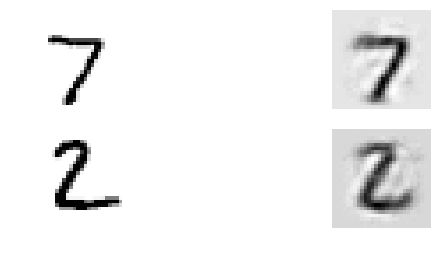

In [19]:
show_reconstructed_digits(inputs, outputs, './model/stacked_ae_tying.ckpt')